## 6. No Supervisado con PCA

Importamos las librerias:

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import pickle


Cargamos nuestro Dataframe

In [2]:
train = pd.read_csv('../data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5197 non-null   float64
 1   volatile acidity      5197 non-null   float64
 2   citric acid           5197 non-null   float64
 3   residual sugar        5197 non-null   float64
 4   chlorides             5197 non-null   float64
 5   free sulfur dioxide   5197 non-null   float64
 6   total sulfur dioxide  5197 non-null   float64
 7   density               5197 non-null   float64
 8   pH                    5197 non-null   float64
 9   sulphates             5197 non-null   float64
 10  alcohol               5197 non-null   float64
 11  quality               5197 non-null   int64  
 12  type_num              5197 non-null   int64  
 13  alc-sug               5197 non-null   float64
 14  qua-sug               5197 non-null   float64
dtypes: float64(13), int64

Igualamos los valores del target con RandomOverSampler

In [3]:
X = train.drop(columns=['quality'])  
y = train['quality']  

oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

Generamos las nuevas X e y 

In [4]:
X=df_balanced.drop(columns=['quality'])
y=df_balanced['quality']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

Creamos el pipe con las opciones de Scaler, PCA y RandomForestClassifier

In [ ]:
from sklearn.decomposition import PCA

pipe_gs_rf_pca = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])
params = {
    "scaler" : [StandardScaler(), None],
    "pca__n_components": [5,7,10],
    "classifier__max_depth": [5,7,10],
    "classifier__min_samples_leaf": [2,3,4],
    'classifier__n_estimators': [50, 100, 200],
}

Ejecutamos el GrisSearch para encontrar el mejor modelo con el pipeline

In [19]:
pca = GridSearchCV(pipe_gs_rf_pca, params, cv=5, scoring="accuracy", n_jobs=-1)

pca.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 7, 10],
                         'classifier__min_samples_leaf': [2, 3, 4],
                         'classifier__n_estimators': [50, 100, 200],
                         'pca__n_components': [5, 7, 10],
                         'scaler': [StandardScaler(), None]},
             scoring='accuracy')

In [20]:
print(pca.best_params_)
print(pca.best_score_)
print(pca.best_estimator_)

{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100, 'pca__n_components': 10, 'scaler': StandardScaler()}
0.8501465501695613
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2))])


Elegimos el mejor modelo posible

In [21]:
final_pca = pca.best_estimator_.fit(X_train, y_train)
y_pred = final_pca.predict(X_test)


Evaluamos los resultados y generamos la matriz de confusión

In [22]:
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [23]:
print("Matriz de Confusión:")
print(cm)
print("\nTasa de Aciertos (Accuracy): {:.2f}%".format(accuracy * 100))

Matriz de Confusión:
[[449   0   0   0   0   0   0]
 [  0 451  16   5   0   0   0]
 [  1  28 346  63  25   1   0]
 [  1  14 131 199  92  11   0]
 [  0   1  26  41 381   6   1]
 [  0   0   1   4   0 430   0]
 [  0   0   0   0   0   0 436]]

Tasa de Aciertos (Accuracy): 85.19%


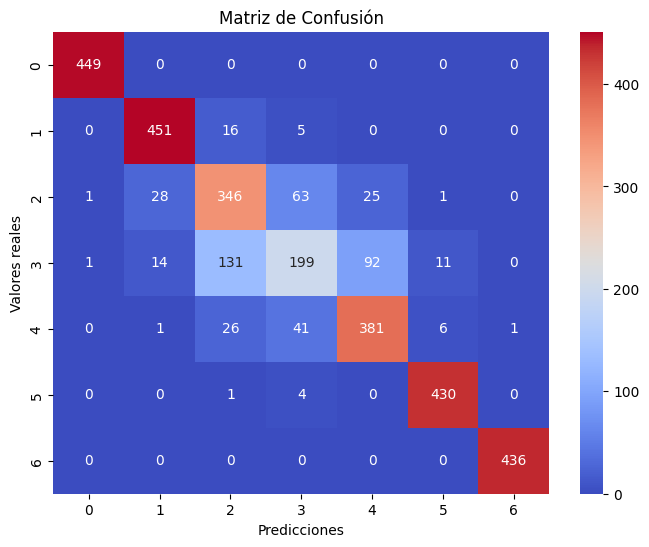

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

Guardamos nuestro modelo en un archivo .pkl 

In [25]:
with open('../models/trained_model_6PCA.pkl', 'wb') as archivo_salida :
    pickle.dump(final_pca, archivo_salida)